# CP 322 - Final Project

Aditya Chauhan (169027493)

## Introduction

### Dataset Choice

- [Student Performance Dataset](https://archive.ics.uci.edu/dataset/320/student+performance)

### Business Understanding

The purpose of this predictive model is to analyze the factors influencing students' final grades (G3). The model leverages descriptive features relevant to final grades and aims to provide actionable insights into the key predictors of academic success. Institutions could use this model to identify students at risk for underperforming, allocate resources more effectiely, and improve academic outcomes. It supports evidence-based decision-making for parents, teachers, policymakers, and students.

Key Research Questions:

- What are the most significant factors influencing students' final grades (G3)
- How does early academic performance (G1 & G2) correlate with final outcomes (G3)
- Can external factors such as familial support, alcohol consumption, and absences, predict student's academic success?

## Data Understanding & Preparation

### Imports

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
import seaborn as sns
from scipy.stats import zscore

### Read/Load Data

In [29]:
# Load the datasets
student_mat = pd.read_csv("Data/student-mat.csv", sep=";")
student_por = pd.read_csv("Data/student-por.csv", sep=";")

# Merge datasets on specified columns
merge_columns = [
    "school", "sex", "age", "address", "famsize", "Pstatus", 
    "Medu", "Fedu", "Mjob", "Fjob", "reason", "nursery", "internet"
]
merged_data = pd.merge(student_mat, student_por, on=merge_columns, suffixes=('_mat', '_por'))

# Save the merged dataset
merged_data.to_csv("student-merged.csv", index=False)
print("Number of students in merged dataset:", merged_data.shape[0])
print("Merged dataset saved to 'student-merged.csv'.")

Number of students in merged dataset: 382
Merged dataset saved to 'student-merged.csv'.


### Data Cleaning

In [30]:
# Resolve Duplicate Columns
columns_to_keep = [
    'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 
    'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'nursery', 'internet',
    'guardian_mat', 'traveltime_mat', 'studytime_mat', 'failures_mat', 'schoolsup_mat', 
    'famsup_mat', 'paid_mat', 'activities_mat', 'higher_mat', 'romantic_mat', 
    'famrel_mat', 'freetime_mat', 'goout_mat', 'Dalc_mat', 'Walc_mat', 'health_mat', 
    'absences_mat', 'G1_mat', 'G2_mat', 'G3_mat'
]

# Retain the '_mat' versions and rename columns to remove suffix
merged_data = merged_data[columns_to_keep]
merged_data.columns = [col.replace('_mat', '') for col in merged_data.columns]

# Standardize Column Names
merged_data.columns = merged_data.columns.str.lower().str.strip().str.replace(' ', '_').str.replace('-', '_')
print("Standardized column names:")
print(merged_data.columns.tolist())

# Handle Missing Values
# Fill numeric columns with the median
numeric_columns = merged_data.select_dtypes(include=['int64', 'float64']).columns
merged_data[numeric_columns] = merged_data[numeric_columns].fillna(merged_data[numeric_columns].median())

# Fill categorical columns with the mode
categorical_columns = merged_data.select_dtypes(include=['object']).columns
merged_data[categorical_columns] = merged_data[categorical_columns].fillna(merged_data[categorical_columns].mode().iloc[0])

# Remove Duplicates
duplicates = merged_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

merged_data.drop_duplicates(inplace=True)
print(f"Shape after removing duplicates: {merged_data.shape}")

# Remove Invalid Entries
# Remove invalid or implausible entries for age and G3
merged_data = merged_data[(merged_data['age'] >= 15) & (merged_data['age'] <= 22)]
merged_data = merged_data[(merged_data['g3'] >= 0) & (merged_data['g3'] <= 20)]
print("Shape after removing invalid entries:", merged_data.shape)

# Consolidate Redundant Features
# Combine guardian_mat and guardian_por (if both exist)
if 'guardian_mat' in merged_data.columns and 'guardian_por' in merged_data.columns:
    merged_data['guardian'] = merged_data[['guardian_mat', 'guardian_por']].mode(axis=1)[0]
    merged_data.drop(columns=['guardian_mat', 'guardian_por'], inplace=True)

print("Shape after consolidating redundant features:", merged_data.shape)

# Validate Data Consistency
# Standardize categorical values
if 'school' in merged_data.columns:
    print("Unique values in 'school':", merged_data['school'].unique())
    merged_data['school'] = merged_data['school'].str.upper()

# Remove Outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

columns_to_check = ['absences', 'g1', 'g2', 'g3']
for col in columns_to_check:
    merged_data = remove_outliers(merged_data, col)

# Verify Final Dataset
print("Final dataset shape:", merged_data.shape)
print("Sample data after cleaning:")
print(merged_data.head())

# Save the Cleaned Dataset
merged_data.to_csv("student-merged-cleaned.csv", index=False)
print("Cleaned dataset saved to 'student-merged-cleaned.csv'.")

Standardized column names:
['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu', 'mjob', 'fjob', 'reason', 'nursery', 'internet', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'higher', 'romantic', 'famrel', 'freetime', 'goout', 'dalc', 'walc', 'health', 'absences', 'g1', 'g2', 'g3']
Number of duplicate rows: 12
Shape after removing duplicates: (370, 33)
Shape after removing invalid entries: (370, 33)
Shape after consolidating redundant features: (370, 33)
Unique values in 'school': ['GP' 'MS']
Final dataset shape: (323, 33)
Sample data after cleaning:
  school sex  age address famsize pstatus  medu  fedu     mjob      fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4

### Derived/Created Features

In [31]:
# Derived/Created Features

# 1. Average Early Grades (G1 and G2)
merged_data['avg_early_grades'] = (merged_data['g1'] + merged_data['g2']) / 2

# 2. Combined Parental Education
merged_data['parental_education'] = (merged_data['medu'] + merged_data['fedu']) / 2

# 3. Total Alcohol Consumption
merged_data['total_alcohol'] = merged_data['dalc'] + merged_data['walc']

# 4. High Absenteeism
median_absences = merged_data['absences'].median()
merged_data['high_absences'] = merged_data['absences'].apply(lambda x: 1 if x > median_absences else 0)

# 5. Failures Weighted by Study Time
merged_data['failure_study_ratio'] = merged_data['failures'] / (merged_data['studytime'] + 1)

# 6. Early Grade Improvement
merged_data['grade_improvement'] = merged_data['g2'] - merged_data['g1']

# 7. Weekend vs Weekday Alcohol Ratio
merged_data['alc_ratio'] = merged_data['walc'] / (merged_data['dalc'] + 1)

# Verify the new features
print("Sample data with new features:")
print(merged_data[['avg_early_grades', 'parental_education', 'total_alcohol', 'high_absences', 
                   'failure_study_ratio', 'grade_improvement', 'alc_ratio']].head())

Sample data with new features:
   avg_early_grades  parental_education  total_alcohol  high_absences  \
0               5.5                 4.0              2              1   
1               5.0                 1.0              2              0   
2               7.5                 1.0              5              1   
3              14.5                 3.0              2              0   
4               8.0                 3.0              3              0   

   failure_study_ratio  grade_improvement  alc_ratio  
0                  0.0                  1        0.5  
1                  0.0                  0        0.5  
2                  1.0                  1        1.0  
3                  0.0                 -1        0.5  
4                  0.0                  4        1.0  


### Data Normalization

In [32]:
# Select numeric columns
numeric_columns = merged_data.select_dtypes(include=['int64', 'float64']).columns

# Create pipelines for both scaling methods
def preprocess_data(data, scaler):
    """
    Function to preprocess data using the specified scaler.
    
    Parameters:
    - data: pandas DataFrame, the dataset to scale.
    - scaler: Scikit-learn scaler object (e.g., StandardScaler, RobustScaler).
    
    Returns:
    - scaled_data: pandas DataFrame, the scaled dataset.
    """
    scaled_data = data.copy()
    scaled_data[numeric_columns] = scaler.fit_transform(scaled_data[numeric_columns])
    return scaled_data

# Preprocess using Z-Score Normalization
zscore_scaler = StandardScaler()
zscore_data = preprocess_data(merged_data, zscore_scaler)
print("Z-Score Normalized Data Sample:")
print(zscore_data.head())

# Preprocess using Robust Scaling
robust_scaler = RobustScaler()
robust_data = preprocess_data(merged_data, robust_scaler)
print("Robust Scaled Data Sample:")
print(robust_data.head())

# Save preprocessed datasets for future use
zscore_data.to_csv("student-zscore-normalized.csv", index=False)
robust_data.to_csv("student-robust-scaled.csv", index=False)

print("Preprocessed datasets saved:")
print("- Z-Score Normalized Dataset: 'student-zscore-normalized.csv'")
print("- Robust Scaled Dataset: 'student-robust-scaled.csv'")

Z-Score Normalized Data Sample:
  school sex       age address famsize pstatus      medu      fedu     mjob  \
0     GP   F  1.275153       U     GT3       A  1.082413  1.321009  at_home   
1     GP   F  0.417081       U     GT3       T -1.670495 -1.455689  at_home   
2     GP   F -1.299063       U     LE3       T -1.670495 -1.455689  at_home   
3     GP   F -1.299063       U     GT3       T  1.082413 -0.530123   health   
4     GP   F -0.440991       U     GT3       T  0.164777  0.395443    other   

       fjob  ...        g1        g2        g3 avg_early_grades  \
0   teacher  ... -1.934116 -1.704848 -1.730933        -1.865749   
1     other  ... -1.934116 -2.019695 -1.730933        -2.025346   
2     other  ... -1.317718 -1.075156 -0.495372        -1.227363   
3  services  ...  1.147875  0.813921  1.049079         1.006991   
4     other  ... -1.625917 -0.445464 -0.495372        -1.067766   

   parental_education  total_alcohol  high_absences failure_study_ratio  \
0            1.

### Data Quality Report

In [33]:
def generate_complete_data_quality_report(df, target_feature=None):
    """
    Generate a comprehensive data quality report for a given DataFrame.
    
    Parameters:
    - df: pandas DataFrame, the dataset to analyze.
    - target_feature: str, the name of the target feature (optional) for special focus.
    
    Returns:
    - data_quality_report: pandas DataFrame with key insights.
    """
    # Initialize the report
    data_quality_report = pd.DataFrame({
        "Column Name": df.columns,
        "Data Type": df.dtypes.values,
        "Number of Unique Values": df.nunique().values,
        "Number of Missing Values": df.isnull().sum().values,
        "Percentage of Missing Values (%)": (df.isnull().sum() / len(df) * 100).values,
        "Mean": [df[col].mean() if df[col].dtype in ['int64', 'float64'] else None for col in df.columns],
        "Median": [df[col].median() if df[col].dtype in ['int64', 'float64'] else None for col in df.columns],
        "Standard Deviation": [df[col].std() if df[col].dtype in ['int64', 'float64'] else None for col in df.columns],
        "Minimum": [df[col].min() if df[col].dtype in ['int64', 'float64'] else None for col in df.columns],
        "Maximum": [df[col].max() if df[col].dtype in ['int64', 'float64'] else None for col in df.columns],
        "Top Value (Mode)": [df[col].mode()[0] if not df[col].mode().empty else None for col in df.columns],
        "Frequency of Top Value": [df[col].value_counts().iloc[0] if not df[col].value_counts().empty else None for col in df.columns]
    })
    
    # Save report to a CSV file
    data_quality_report.to_csv("data_quality_report.csv", index=False)
    print("Data Quality Report saved as 'updated_data_quality_report.csv'.")
    
    # Check for outliers (z-score method)
    outlier_report = {}
    for col in numeric_columns:
        z_scores = zscore(df[col].dropna())
        outlier_count = np.sum(np.abs(z_scores) > 3)
        outlier_report[col] = outlier_count
    print("\nOutlier Counts per Numeric Feature:")
    print(outlier_report)
    
    # Class imbalance for target feature (if provided)
    if target_feature and target_feature in df.columns:
        print(f"\nClass Distribution for Target Feature ({target_feature}):")
        print(df[target_feature].value_counts(normalize=True))
    
    return data_quality_report, outlier_report

# Assuming `merged_data` is the cleaned, updated, and normalized dataset
target_feature = 'g3'
data_quality_report, outlier_report = generate_complete_data_quality_report(merged_data, target_feature=target_feature)

Data Quality Report saved as 'updated_data_quality_report.csv'.

Outlier Counts per Numeric Feature:
{'age': np.int64(1), 'medu': np.int64(0), 'fedu': np.int64(0), 'traveltime': np.int64(7), 'studytime': np.int64(0), 'failures': np.int64(10), 'famrel': np.int64(7), 'freetime': np.int64(0), 'goout': np.int64(0), 'dalc': np.int64(9), 'walc': np.int64(0), 'health': np.int64(0), 'absences': np.int64(2), 'g1': np.int64(0), 'g2': np.int64(0), 'g3': np.int64(0), 'avg_early_grades': np.int64(0), 'parental_education': np.int64(0), 'total_alcohol': np.int64(9), 'high_absences': np.int64(0), 'failure_study_ratio': np.int64(12), 'grade_improvement': np.int64(0), 'alc_ratio': np.int64(4)}

Class Distribution for Target Feature (g3):
g3
10    0.167183
11    0.126935
15    0.099071
8     0.089783
12    0.086687
14    0.083591
13    0.074303
9     0.068111
16    0.049536
6     0.043344
18    0.030960
5     0.021672
7     0.021672
17    0.018576
19    0.015480
20    0.003096
Name: proportion, dtype: fl

### Visualizations


Bar Plots for Categorical features: 



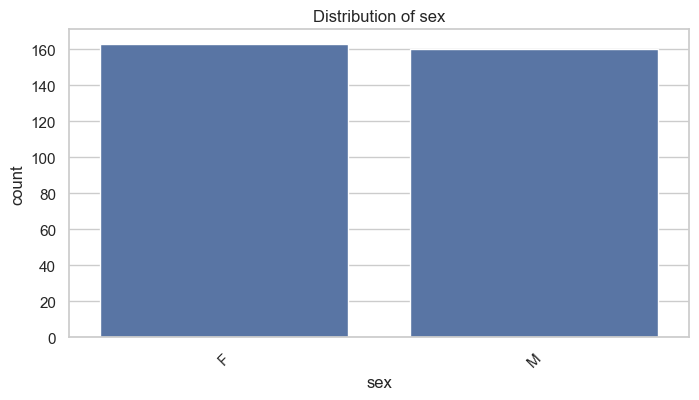

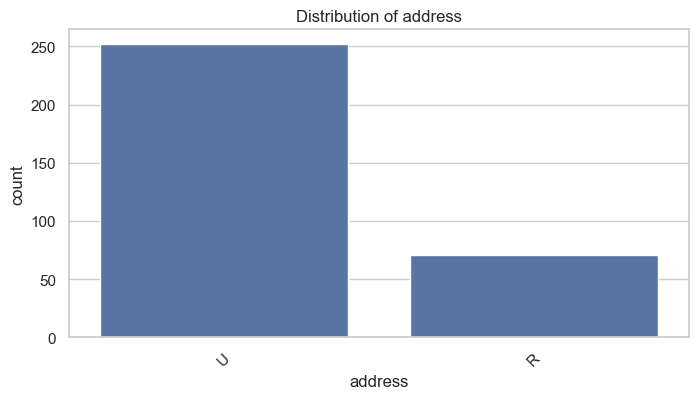

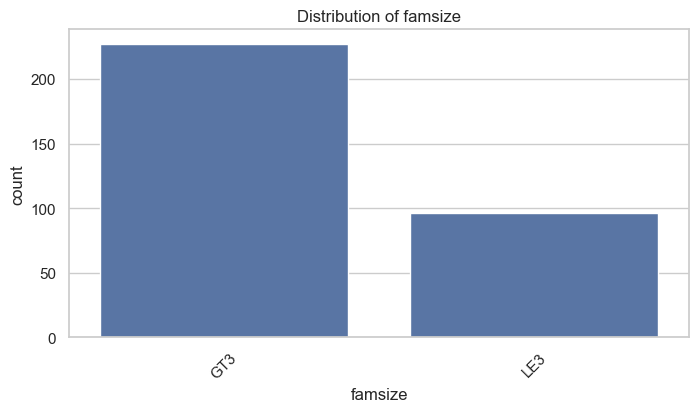

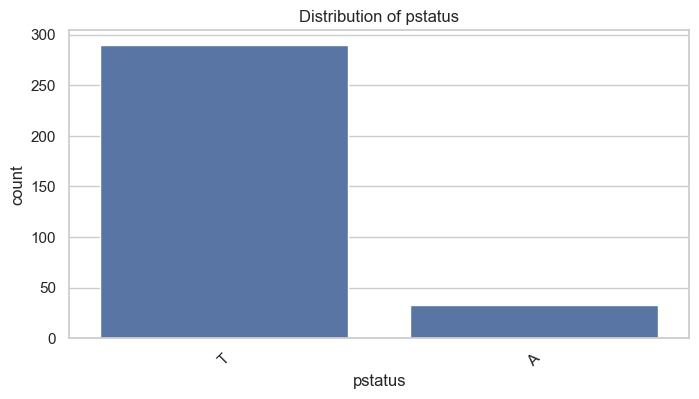

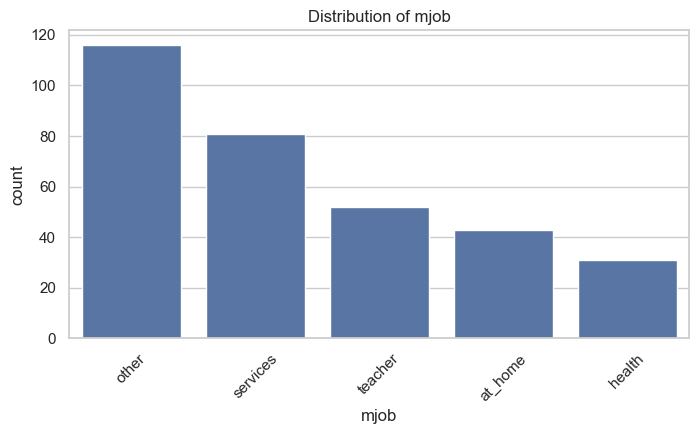

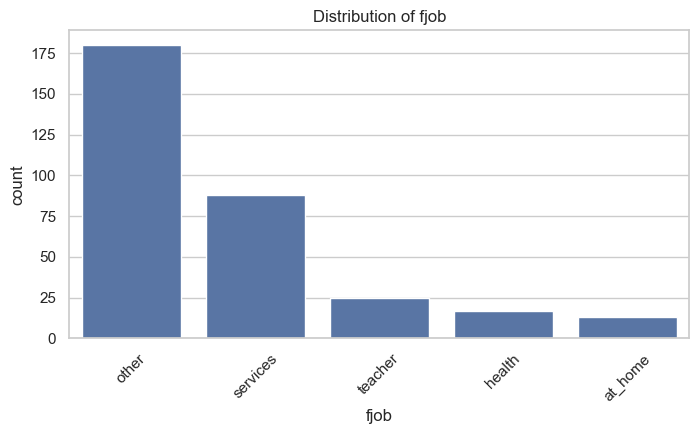

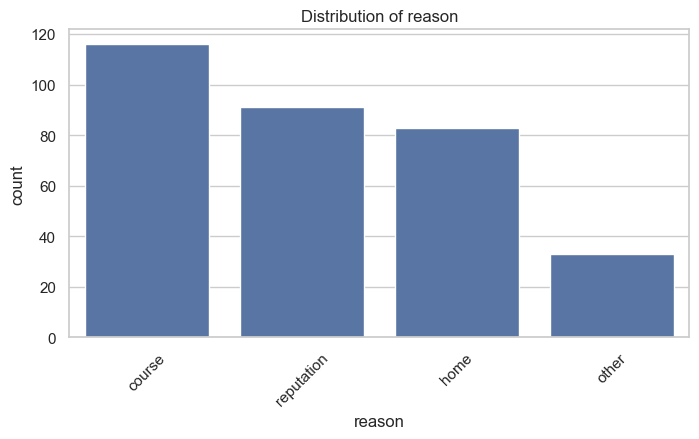

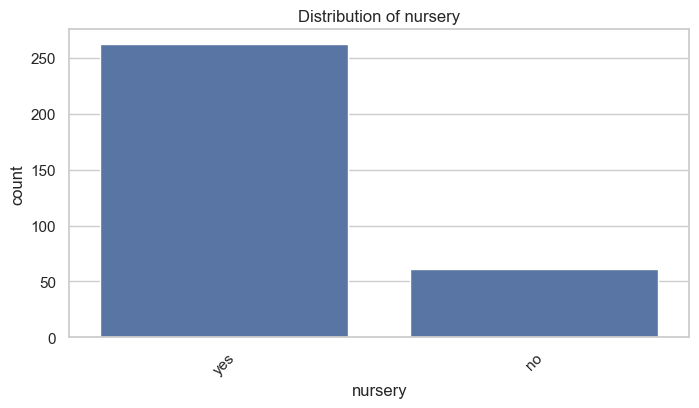

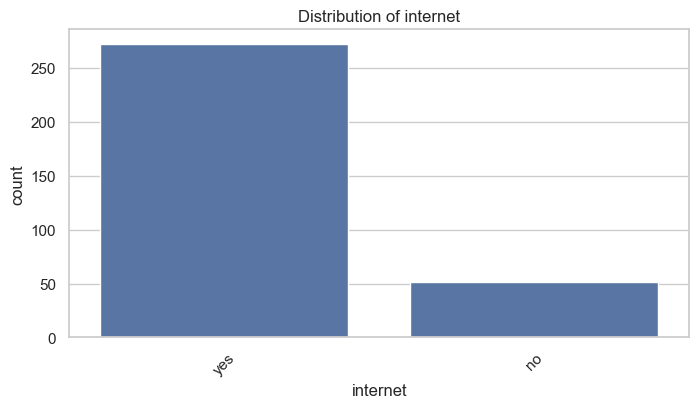

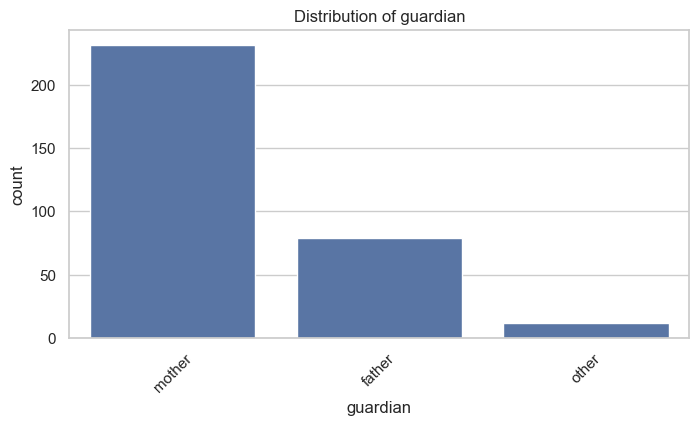


G3 Histogram: 



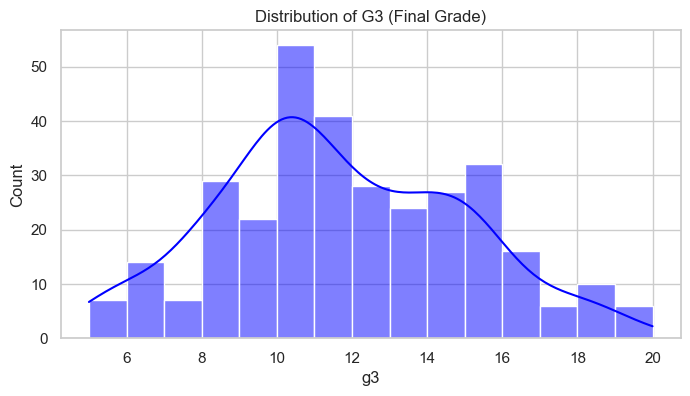


Pairwise Relationships: 



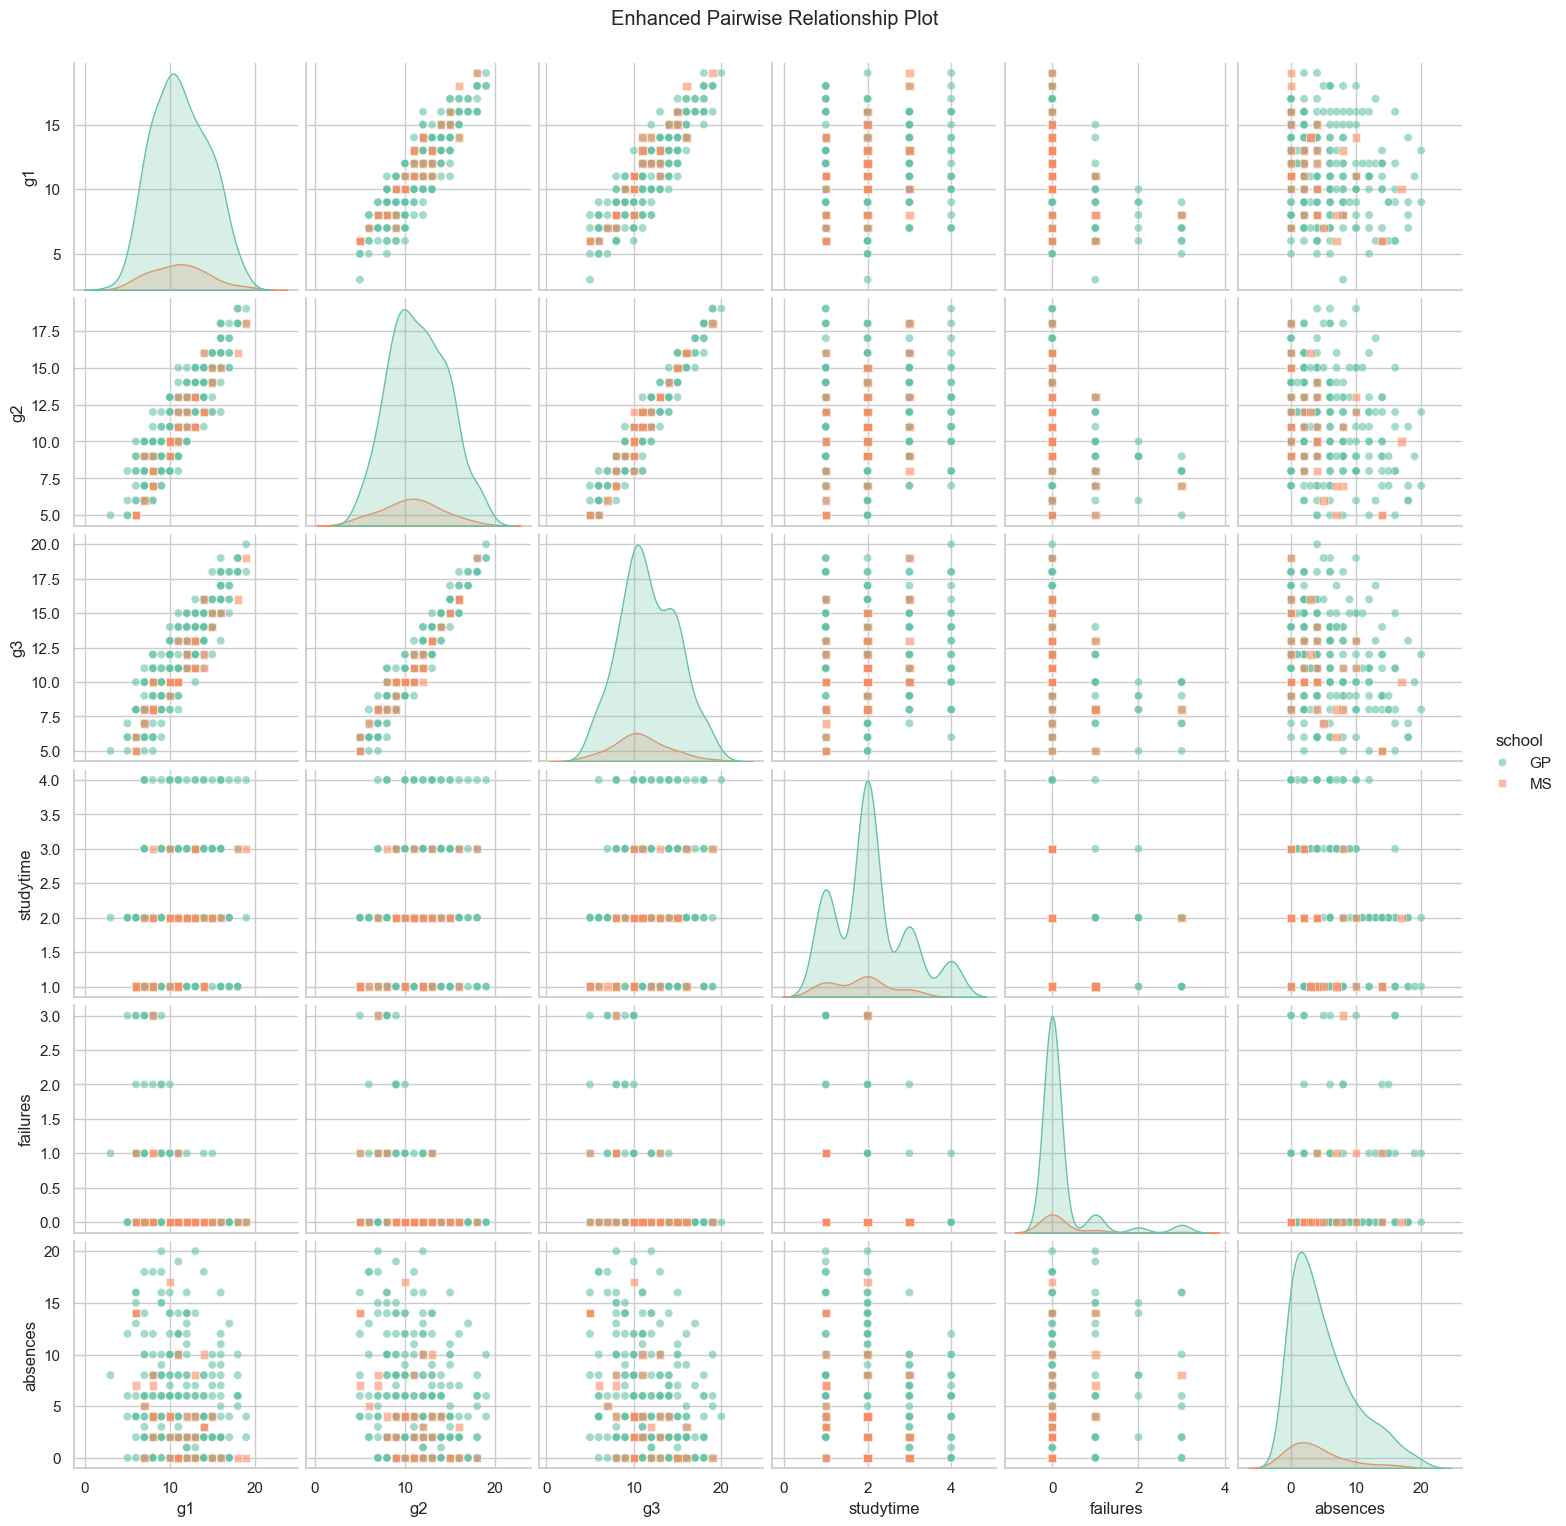


Correlation Matrix: 



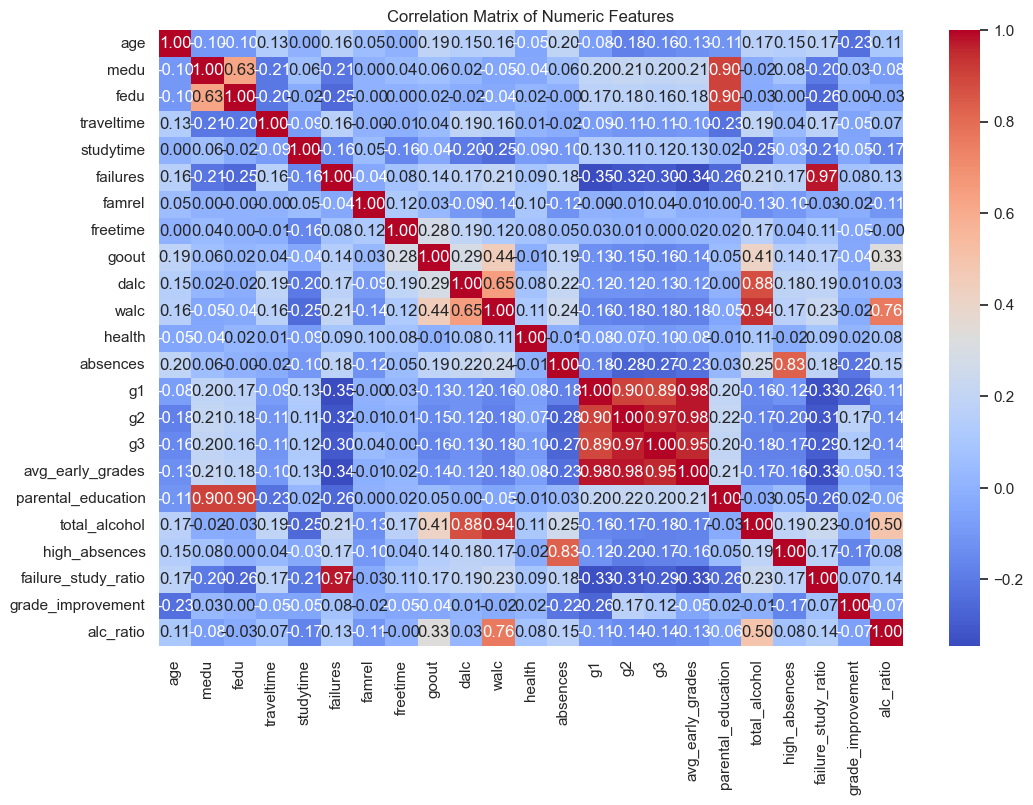

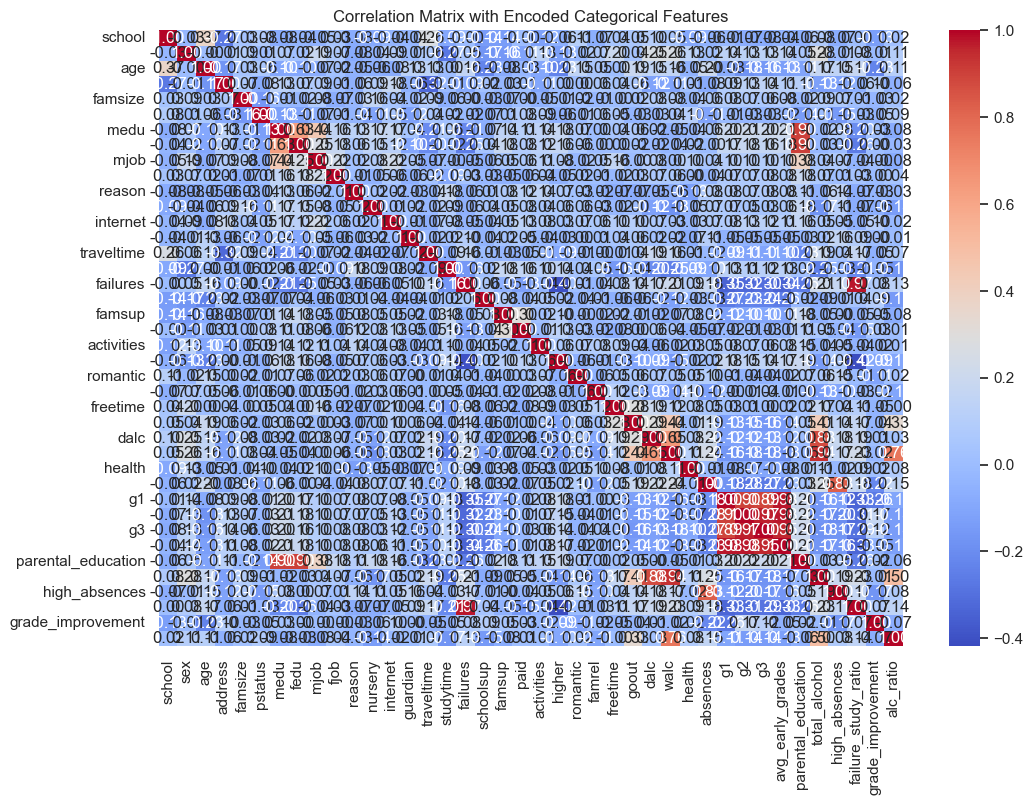


Alcohol Consumption Box Plot: 



/var/folders/f6/s4dd89s15253_7034mv9vb3h0000gn/T/ipykernel_1720/2794932582.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data, x='walc', y='g3', palette='viridis')


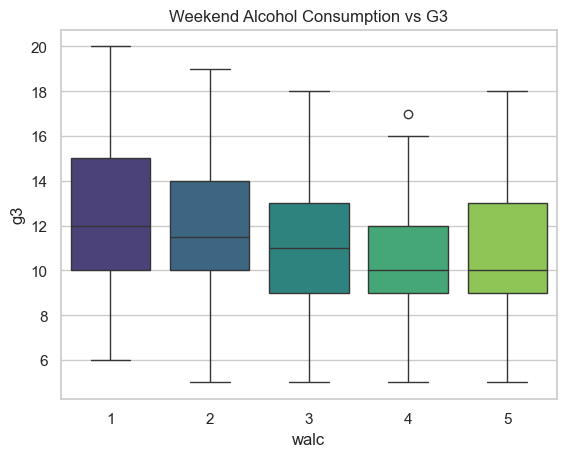

/var/folders/f6/s4dd89s15253_7034mv9vb3h0000gn/T/ipykernel_1720/2794932582.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data, x='dalc', y='g3', palette='magma')


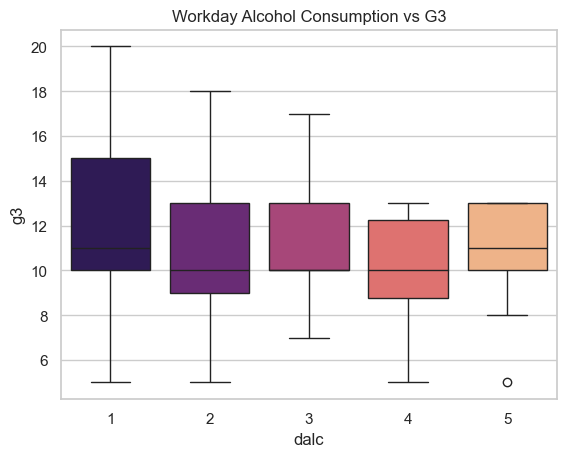


Parental Education Box Plot: 



/var/folders/f6/s4dd89s15253_7034mv9vb3h0000gn/T/ipykernel_1720/2794932582.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data, x='medu', y='g3', palette='coolwarm')


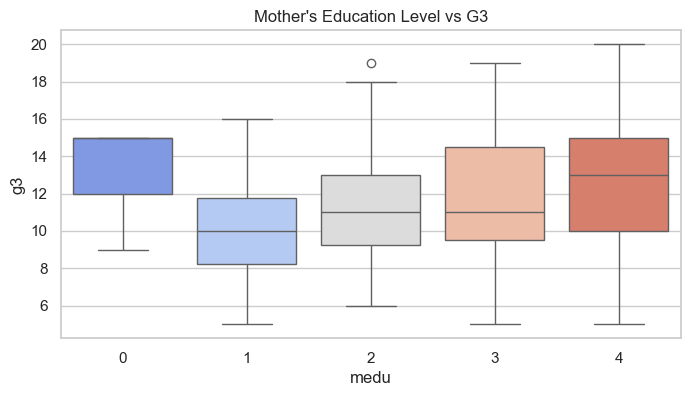

/var/folders/f6/s4dd89s15253_7034mv9vb3h0000gn/T/ipykernel_1720/2794932582.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data, x='fedu', y='g3', palette='coolwarm')


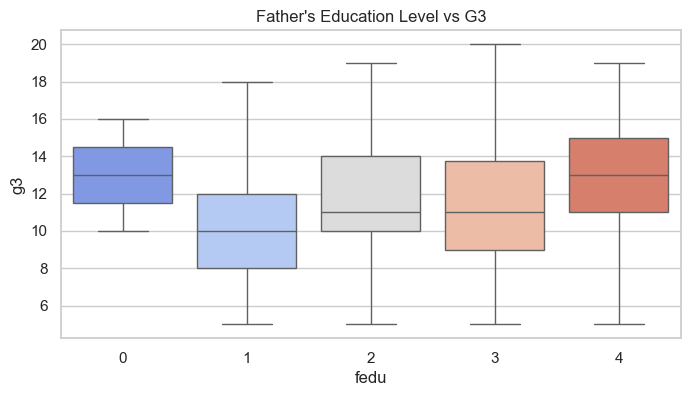


Key Feature -> Target Relationships: 



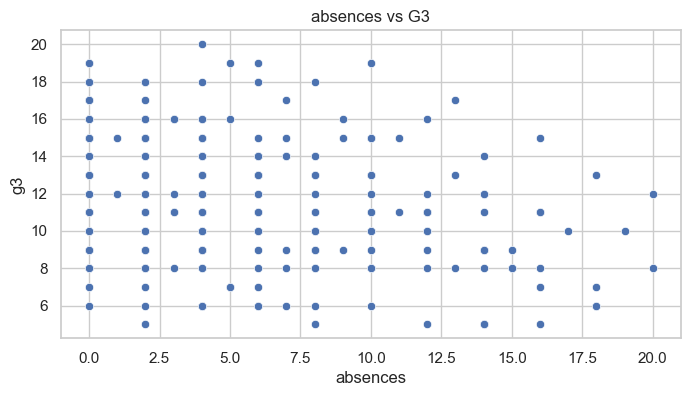

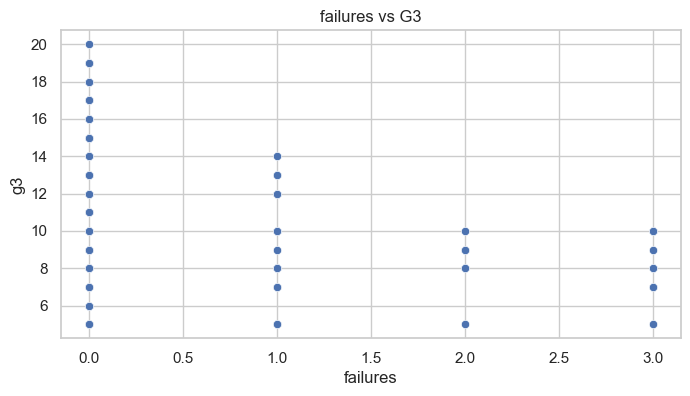

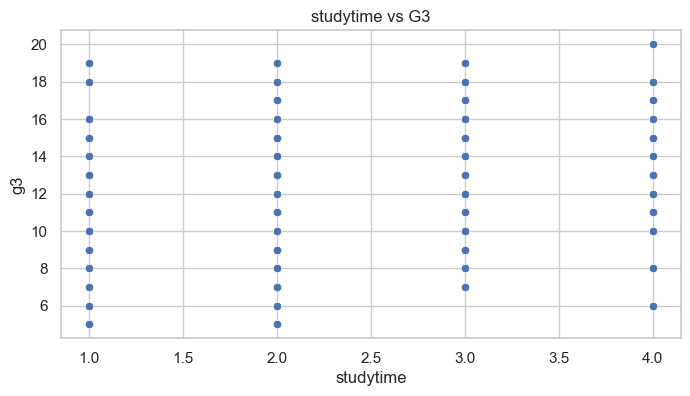

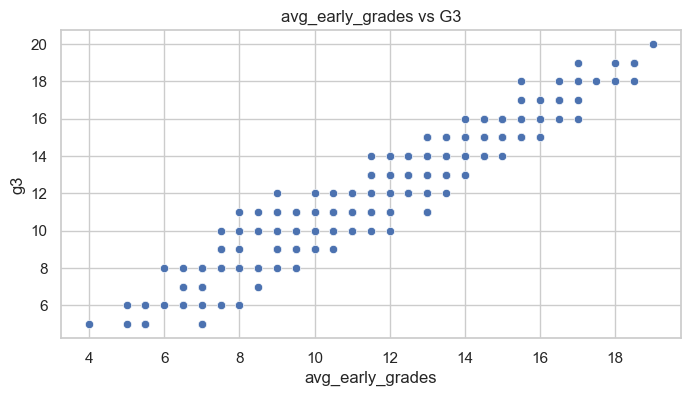

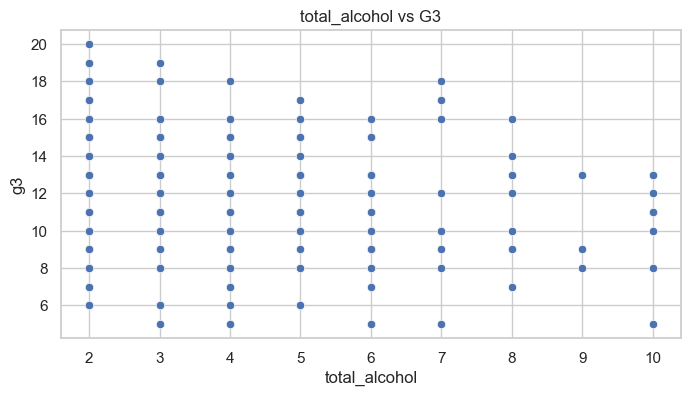


Study Time Violin Plot: 



/var/folders/f6/s4dd89s15253_7034mv9vb3h0000gn/T/ipykernel_1720/2794932582.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_data, x='studytime', y='g3', palette='muted')


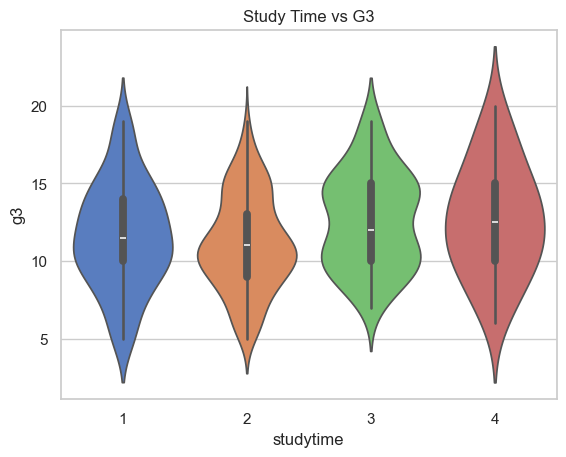


Categorical Feature Interaction: 



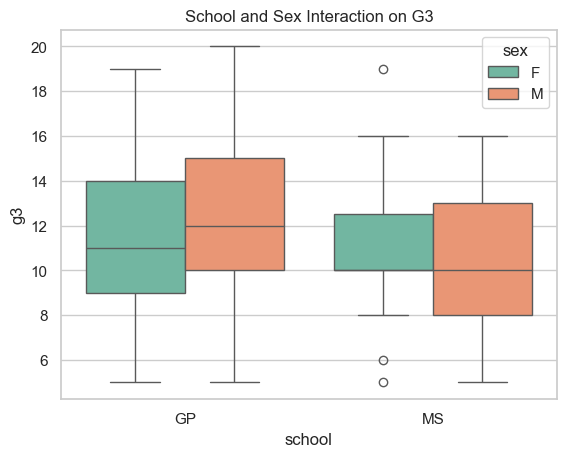


High Absence Distribution Box Plot: 



/var/folders/f6/s4dd89s15253_7034mv9vb3h0000gn/T/ipykernel_1720/2794932582.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data, x='high_absences', y='g3', palette='coolwarm')


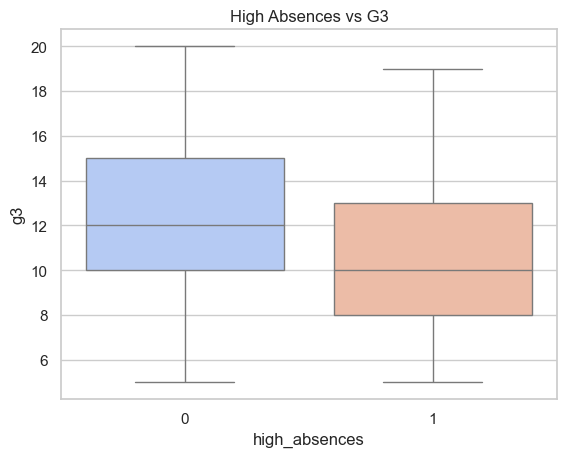


Study Time Investment Vs Final Grade: 



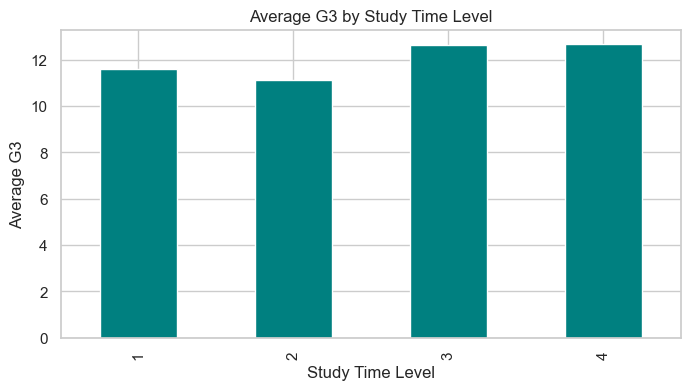

In [34]:
print("\nBar Plots for Categorical features: \n")
categorical_features = ['sex', 'address', 'famsize', 'pstatus', 'mjob', 'fjob', 'reason', 'nursery', 'internet', 'guardian']
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=merged_data, x=feature, order=merged_data[feature].value_counts().index)
    plt.title(f"Distribution of {feature}")
    plt.xticks(rotation=45)
    plt.show()


print("\nG3 Histogram: \n")
plt.figure(figsize=(8, 4))
sns.histplot(merged_data['g3'], kde=True, bins=15, color='blue')
plt.title("Distribution of G3 (Final Grade)")
plt.show()

print("\nPairwise Relationships: \n")
variables = ['g1', 'g2', 'g3', 'studytime', 'failures', 'absences']
hue_feature = 'school'  # You can change this to another categorical variable (e.g., 'sex')

# Create the pairplot
sns.set(style="whitegrid")
pairplot = sns.pairplot(
    merged_data[variables + [hue_feature]],
    hue=hue_feature,
    palette="Set2",
    diag_kind="kde",  # Use KDE for diagonal plots
    markers=["o", "s"],  # Different markers for hue categories
    height=2.5,  # Adjust the plot size
    plot_kws={'alpha': 0.6},  # Add transparency to scatter points
    diag_kws={'fill': True}  # Updated to use 'fill' instead of 'shade'
)

# Add a title
pairplot.fig.suptitle("Enhanced Pairwise Relationship Plot", y=1.02)
plt.show()

print("\nCorrelation Matrix: \n")
numeric_columns = merged_data.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

categorical_columns = merged_data.select_dtypes(include=['object']).columns
encoded_data = merged_data.copy()
for col in categorical_columns:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(encoded_data[col])

# Now calculate correlation with encoded data
correlation_matrix = encoded_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix with Encoded Categorical Features")
plt.show()

print("\nAlcohol Consumption Box Plot: \n")
sns.boxplot(data=merged_data, x='walc', y='g3', palette='viridis')
plt.title("Weekend Alcohol Consumption vs G3")
plt.show()

sns.boxplot(data=merged_data, x='dalc', y='g3', palette='magma')
plt.title("Workday Alcohol Consumption vs G3")
plt.show()

print("\nParental Education Box Plot: \n")
plt.figure(figsize=(8, 4))
sns.boxplot(data=merged_data, x='medu', y='g3', palette='coolwarm')
plt.title("Mother's Education Level vs G3")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=merged_data, x='fedu', y='g3', palette='coolwarm')
plt.title("Father's Education Level vs G3")
plt.show()

print("\nKey Feature -> Target Relationships: \n")
numeric_features = ['absences', 'failures', 'studytime', 'avg_early_grades', 'total_alcohol']
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=merged_data, x=feature, y='g3')
    plt.title(f"{feature} vs G3")
    plt.show()

print("\nStudy Time Violin Plot: \n")
sns.violinplot(data=merged_data, x='studytime', y='g3', palette='muted')
plt.title("Study Time vs G3")
plt.show()

print("\nCategorical Feature Interaction: \n")
sns.boxplot(data=merged_data, x='school', y='g3', hue='sex', palette='Set2')
plt.title("School and Sex Interaction on G3")
plt.show()

print("\nHigh Absence Distribution Box Plot: \n")
sns.boxplot(data=merged_data, x='high_absences', y='g3', palette='coolwarm')
plt.title("High Absences vs G3")
plt.show()

print("\nStudy Time Investment Vs Final Grade: \n")
studytime_g3 = merged_data.groupby('studytime')['g3'].mean()
studytime_g3.plot(kind='bar', color='teal', figsize=(8, 4))
plt.title("Average G3 by Study Time Level")
plt.ylabel("Average G3")
plt.xlabel("Study Time Level")
plt.show()

## Experimental Design

## Modelling

## Evaluation & Deployment